# **Feature Extraction for Phishing Detection Machine Learning Model**

### *By Mateo Minghi & Enrique Ayala*

## **1. Data**

In this project, we are using 3 different datasets, provided by:
1. [PhishTank](https://phishtank.com/developer_info.php)
2. Kaggle
    - [Malicious URLs dataset](https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset)
    - [Phishing URLs dataset](https://www.kaggle.com/datasets/taruntiwarihp/phishing-site-urls)

### **1.1. Data Understanding**

Here we are importing the different datasets, and starting the Data Understanding module for this project.

In [91]:
# %pip install datasets

In [92]:
# Required libraries for this module
from datasets import load_dataset
from datasets import Dataset
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Import label encoder
from sklearn import preprocessing, metrics

In [93]:
# Importing Dataset

df = pd.read_csv('Datasets/combined.csv')

In [94]:
# Dataset Shape

print(df.shape)

(1200536, 3)


In [95]:
# Dataset Head

print(df.head())

   Unnamed: 0                                                url Label
0           0                                   br-icloud.com.br   bad
1           1                mp3raid.com/music/krizz_kaliko.html  good
2           2                    bopsecrets.org/rexroth/cr/1.htm  good
3           3  http://www.garage-pirenne.be/index.php?option=...   bad
4           4  http://adventure-nicaragua.net/index.php?optio...   bad


In [96]:
# Dataset Info

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200536 entries, 0 to 1200535
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1200536 non-null  int64 
 1   url         1200536 non-null  object
 2   Label       1200536 non-null  object
dtypes: int64(1), object(2)
memory usage: 27.5+ MB
None


In [97]:
# Group the DataFrame by 'type', randomly select one row from each group, and reset the index

df.groupby('Label').apply(lambda x: x.sample(1)).reset_index(drop=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_32484\2738466268.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('Label').apply(lambda x: x.sample(1)).reset_index(drop=True)


,Unnamed: 0,url,Label
0,401483,alfarerasuroeste.com,bad
1,387520,bbb.org/greater-san-francisco/business-reviews...,good


In [98]:
# Count the NaN values 

df.isna().sum()

Unnamed: 0    0
url           0
Label         0
dtype: int64

### **1.2. Data Distribution**

Here we analyse the composition of the dataset, classifying according to the type of url present in the dataset.  

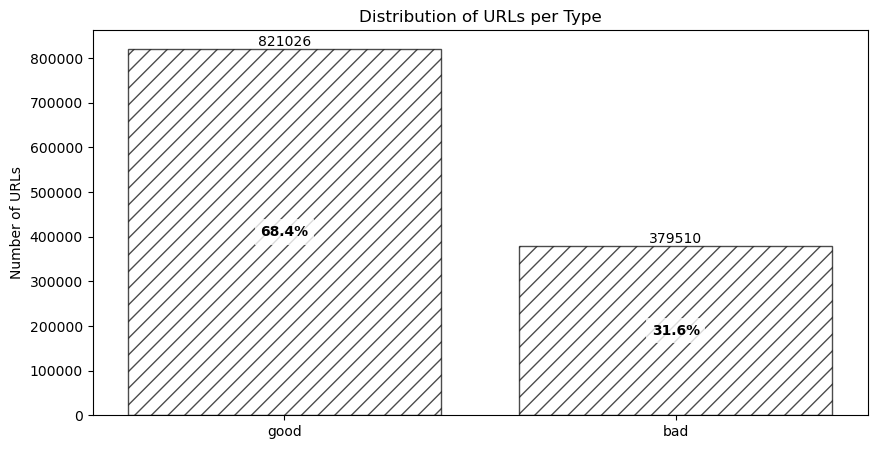

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

types = df['Label'].values

counter_types = Counter(types)

type_names = list(counter_types.keys())
type_values = list(counter_types.values())

sorted_indices = np.argsort(type_values)[::-1]
type_names = [type_names[i] for i in sorted_indices]
type_values = [type_values[i] for i in sorted_indices]

total_count = sum(type_values)
percentages = [value / total_count * 100 for value in type_values]

pattern = '//'

y_pos = np.arange(len(type_names))
plt.figure(1, figsize=(10, 5))
bars = plt.bar(y_pos, type_values, align='center', alpha=0.7, color='none', edgecolor='black', hatch=pattern)

for bar, value, percentage in zip(bars, type_values, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{value}', ha='center', va='bottom')
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{percentage:.1f}%', ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'), fontweight='bold')

plt.xticks(y_pos, type_names)
plt.ylabel('Number of URLs')
plt.title('Distribution of URLs per Type')
plt.show()

Here we can see the complete composition of the dataset, where 68.4% of the URLs are benign, and the remaining 31.6% are Phishing URLs.

### **1.3. Data Preparation**

#### **1.3.1. Label Encoding**



Here, we use LabelEncoder from *SKLEARN.PREPOCESSING* library to convert the categorical values from the *type* column into integers and store them in a new column in the dataset named *type_code*.

In which 0 means Phishing and 1 means benign.

In [100]:
from sklearn.preprocessing import LabelEncoder

le= LabelEncoder()
le.fit(df["Label"])

df["label_code"] = le.transform(df["Label"])
df

,Unnamed: 0,url,Label,label_code
0,0,br-icloud.com.br,bad,0
1,1,mp3raid.com/music/krizz_kaliko.html,good,1
2,2,bopsecrets.org/rexroth/cr/1.htm,good,1
3,3,http://www.garage-pirenne.be/index.php?option=...,bad,0
4,4,http://adventure-nicaragua.net/index.php?optio...,bad,0
...,...,...,...,...
1200531,549340,23.227.196.215/,bad,0
1200532,549341,apple-checker.org/,bad,0
1200533,549342,apple-iclods.org/,bad,0
1200534,549343,apple-uptoday.org/,bad,0


In [101]:
# Label mapping for better understanding
le_label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_label_mapping

{'bad': 0, 'good': 1}

#### **1.3.2 Data Splitting**

In [102]:
df = df[['url', 'Label', 'label_code']]
dataset = Dataset.from_pandas(df, preserve_index=False)

In [103]:
# split train to 80% of total and test to 20% of total
train_test_dataset = dataset.train_test_split(test_size=0.2, seed=42, shuffle=True)

In [104]:
# split the validation test to 10% of total and test set to 10% of total
val_test_dataset = train_test_dataset['test'].train_test_split(test_size=0.5, seed=42, shuffle=True)

In [105]:
from datasets import DatasetDict

# 80% train, 10% validation, 10% test
dataset = DatasetDict({
    'train': train_test_dataset['train'],
    'val': val_test_dataset['train'],
    'test': val_test_dataset['test'],
})

## **2. URLs Feature Extraction**

We extract the next features from the URLs datasets, which will we use in the future for the training of the model.

The features we are looking for are categorized into 1 types:
1. **Static Features**

### **2.1 Static Features**

Static features are those that do not change over time. They are used to describe the properties of the URL itself, below are mentioned the ones considered for this project.
1. Precence of IP address in URL.
2. Count of dot "." symbol in URL.
3. Precence of tilde "~" symbol in URL.
4. Precence of at "@" symbol in URL.
5. Precence of hyphen "-" symbol in URL.
6. Precence of URL Redirection "//".
7. Precence of Sensitive Vocabulary in URL.
8. Precence of shortening services in URL.
9. Precence of "HTTPS" Token in URL.
10. Lenght of URL.
11. Precence of Top-Level Domain Name. 

Each feature will be explained individualy at their respective function below

In [106]:
# Create DataFrames for training, testing, and validation sets from the dataset

df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])
df_val = pd.DataFrame(dataset['val'])

#### **2.1.1 Extracting the IP Address from the URL**

If an IP address is used as an alternative of the domain name in the URL, for example *"http://125.12.34.342/phish.htlm"*, this could be an indicator that this is a suspicious URL.

In this function, which are a series of patterns to identify from an IPv4 IP address using octets or hexadecimal patterns up to IPv6 addresses.

If the Domain section of the URL has an IP address, the value assigned for phishing is 1 or else 0 for legitimate.

In [107]:
import re
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        return 1
    else:
        return 0
df_train['use_of_ip'] = df_train['url'].apply(lambda i: having_ip_address(i))
df_test['use_of_ip'] = df_test['url'].apply(lambda i: having_ip_address(i))

df_train

,url,Label,label_code,use_of_ip
0,http://www.designreisende.de/index.php?option=...,bad,0,0
1,antiquesterling.info/search-results/duchess-of...,good,1,0
2,http://www.vakantiehuislereve.nl/index.php?opt...,bad,0,0
3,amazon.com/Door-Floor-Score-Marcelo-Zarvos/dp/...,good,1,0
4,movieweb.com/news/spaceless-enlists-director-c...,good,1,0
...,...,...,...,...
960423,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,good,1,0
960424,http://mic.com/articles/117896/in-one-tweet-pr...,good,1,0
960425,kivaweb.kcmo.org/kivanet/2/permit/address/inde...,good,1,0
960426,androidosupdate6.com/,bad,0,0


#### **2.1.2. Count of dot "." symbol**

According to a study made by Rami et al. observed that most of phishing websites tended to use more dots in their URL, meanwhile benign URLs usually uses no more than 3 "." symbols.

For example:
- Phishing URL: http://www.example.com.phishing.html
- Legitimate URL: http://www.example.com

Here we considerate the number of "." to represent this feature.

In [108]:
df_train['count.'] = df_train['url'].apply(lambda i: i.count('.'))
df_test['count.'] = df_test['url'].apply(lambda i: i.count('.'))

df_train

,url,Label,label_code,use_of_ip,count.
0,http://www.designreisende.de/index.php?option=...,bad,0,0,3
1,antiquesterling.info/search-results/duchess-of...,good,1,0,2
2,http://www.vakantiehuislereve.nl/index.php?opt...,bad,0,0,3
3,amazon.com/Door-Floor-Score-Marcelo-Zarvos/dp/...,good,1,0,1
4,movieweb.com/news/spaceless-enlists-director-c...,good,1,0,1
...,...,...,...,...,...
960423,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,good,1,0,3
960424,http://mic.com/articles/117896/in-one-tweet-pr...,good,1,0,1
960425,kivaweb.kcmo.org/kivanet/2/permit/address/inde...,good,1,0,3
960426,androidosupdate6.com/,bad,0,0,1


#### **2.1.3. Precence of tilde "~" symbol in URL**

If there is any "~" anyware in the URL, this feature gets assigned the value of 1 (phishing) or else 0 (benign).

In [109]:
def haveTildeSign(url):
    if "∼" in url:
        tilde = 1    
    else:
        tilde = 0    
    return tilde

df_train['∼ Precence'] = df_train['url'].apply(lambda i: haveTildeSign(i))
df_test['∼ Precence'] = df_test['url'].apply(lambda i: haveTildeSign)
df_train

,url,Label,label_code,use_of_ip,count.,∼ Precence
0,http://www.designreisende.de/index.php?option=...,bad,0,0,3,0
1,antiquesterling.info/search-results/duchess-of...,good,1,0,2,0
2,http://www.vakantiehuislereve.nl/index.php?opt...,bad,0,0,3,0
3,amazon.com/Door-Floor-Score-Marcelo-Zarvos/dp/...,good,1,0,1,0
4,movieweb.com/news/spaceless-enlists-director-c...,good,1,0,1,0
...,...,...,...,...,...,...
960423,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,good,1,0,3,0
960424,http://mic.com/articles/117896/in-one-tweet-pr...,good,1,0,1,0
960425,kivaweb.kcmo.org/kivanet/2/permit/address/inde...,good,1,0,3,0
960426,androidosupdate6.com/,bad,0,0,1,0


#### **2.1.4 Precence of at "@" symbol in URL**

The use of "@" symbol in the URL makes the browser to ignore everything before the "@" symbol, for instance, the real address ofter follows the "@" symbol.

For example:
*"http://www.legitbank.com@fakebank.html"*

If the URL contains the "@" symbol, the value assigned for this feature is 1 (phishing) or else 0 (benign)

In [110]:
def haveAtSign(url):
    if "@" in url:
        at = 1    
    else:
        at = 0    
    return at

df_train['@ Precence'] = df_train['url'].apply(lambda i: haveAtSign(i))
df_test['@ Precence'] = df_test['url'].apply(lambda i: haveAtSign(i))
df_train

,url,Label,label_code,use_of_ip,count.,∼ Precence,@ Precence
0,http://www.designreisende.de/index.php?option=...,bad,0,0,3,0,0
1,antiquesterling.info/search-results/duchess-of...,good,1,0,2,0,0
2,http://www.vakantiehuislereve.nl/index.php?opt...,bad,0,0,3,0,0
3,amazon.com/Door-Floor-Score-Marcelo-Zarvos/dp/...,good,1,0,1,0,0
4,movieweb.com/news/spaceless-enlists-director-c...,good,1,0,1,0,0
...,...,...,...,...,...,...,...
960423,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,good,1,0,3,0,0
960424,http://mic.com/articles/117896/in-one-tweet-pr...,good,1,0,1,0,0
960425,kivaweb.kcmo.org/kivanet/2/permit/address/inde...,good,1,0,3,0,0
960426,androidosupdate6.com/,bad,0,0,1,0,0


#### **2.1.5 Precence of hyphen"-" symbol in URL**

The hyphen symbol is rarely used in benign URLs. Most of the time, this is added by the attackers to the domain name so that users think they are in a legimtimate webpage.

For example:
*"http://www.accept-nonrealpage.com"*

If the URL has the "-" symbol in the domain, the value assigned to this feature is 1 (phishing) or else 0 (benign).

In [111]:
def haveHypheSign(url):
    if "-" in url:
        hyphen = 1    
    else:
        hyphen = 0    
    return hyphen

## MAYBE REPLACE TO COUNT

df_train['- Precence'] = df_train['url'].apply(lambda i: haveHypheSign(i))
df_test['- Precence'] = df_test['url'].apply(lambda i: haveHypheSign(i))
df_train

,url,Label,label_code,use_of_ip,count.,∼ Precence,@ Precence,- Precence
0,http://www.designreisende.de/index.php?option=...,bad,0,0,3,0,0,1
1,antiquesterling.info/search-results/duchess-of...,good,1,0,2,0,0,1
2,http://www.vakantiehuislereve.nl/index.php?opt...,bad,0,0,3,0,0,0
3,amazon.com/Door-Floor-Score-Marcelo-Zarvos/dp/...,good,1,0,1,0,0,1
4,movieweb.com/news/spaceless-enlists-director-c...,good,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...
960423,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,good,1,0,3,0,0,1
960424,http://mic.com/articles/117896/in-one-tweet-pr...,good,1,0,1,0,0,1
960425,kivaweb.kcmo.org/kivanet/2/permit/address/inde...,good,1,0,3,0,0,0
960426,androidosupdate6.com/,bad,0,0,1,0,0,0


#### **2.1.6 Precense of URL Redirection "//"**

The implementation of "//" in the URL path means that the user will be redirected to another website. We look for the position where the "//" appear. If the analized URL starts with "HTTP", this could mean that the "//" should appear in the sixth position. However, if the URL starts with "HTTPS", this could mean that the "//" should appear in the seventh position.

For example:
*"http://www.legitpage.com//phishing.html"*

If there is any "//" anyware in the URL, this feature gets assigned the value of 1 (phishing) or else 0 (benign).

In [112]:
from urllib.parse import urlparse
def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df_train['count_embed_domian'] = df_train['url'].apply(lambda i: no_of_embed(i))
df_test['count_embed_domian'] = df_test['url'].apply(lambda i: no_of_embed(i))
df_train

,url,Label,label_code,use_of_ip,count.,∼ Precence,@ Precence,- Precence,count_embed_domian
0,http://www.designreisende.de/index.php?option=...,bad,0,0,3,0,0,1,0
1,antiquesterling.info/search-results/duchess-of...,good,1,0,2,0,0,1,0
2,http://www.vakantiehuislereve.nl/index.php?opt...,bad,0,0,3,0,0,0,0
3,amazon.com/Door-Floor-Score-Marcelo-Zarvos/dp/...,good,1,0,1,0,0,1,0
4,movieweb.com/news/spaceless-enlists-director-c...,good,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...
960423,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,good,1,0,3,0,0,1,0
960424,http://mic.com/articles/117896/in-one-tweet-pr...,good,1,0,1,0,0,1,0
960425,kivaweb.kcmo.org/kivanet/2/permit/address/inde...,good,1,0,3,0,0,0,0
960426,androidosupdate6.com/,bad,0,0,1,0,0,0,0


#### **2.1.7 Precense of Sensitive Vocabulray in URL** add siimlar brands

If the URL has any suspicious words in the URL, the value assigned to this feature is 1 (phishing) or else 0 (benign).

In [113]:
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0

df_train['sus_url'] = df_train['url'].apply(lambda i: suspicious_words(i))
df_test['sus_url'] = df_test['url'].apply(lambda i: suspicious_words(i))
df_train

,url,Label,label_code,use_of_ip,count.,∼ Precence,@ Precence,- Precence,count_embed_domian,sus_url
0,http://www.designreisende.de/index.php?option=...,bad,0,0,3,0,0,1,0,0
1,antiquesterling.info/search-results/duchess-of...,good,1,0,2,0,0,1,0,0
2,http://www.vakantiehuislereve.nl/index.php?opt...,bad,0,0,3,0,0,0,0,0
3,amazon.com/Door-Floor-Score-Marcelo-Zarvos/dp/...,good,1,0,1,0,0,1,0,0
4,movieweb.com/news/spaceless-enlists-director-c...,good,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
960423,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,good,1,0,3,0,0,1,0,0
960424,http://mic.com/articles/117896/in-one-tweet-pr...,good,1,0,1,0,0,1,0,0
960425,kivaweb.kcmo.org/kivanet/2/permit/address/inde...,good,1,0,3,0,0,0,0,0
960426,androidosupdate6.com/,bad,0,0,1,0,0,0,0,1


#### **2.1.8 Precense of shortening services in URL**

The URL shortening is a method on the "WWW" that makes an URL considerably smaller in leght and that still redirects to the required website. This is done thanks by an "HTTP Redirect" on the domain name that is shorter than the long URL.

For example:
The domain *"http://www.legit.com"* could be shortened to *"sh.rt/123ss123"*

If the URL uses a shortening service, the value assigned for this feature is 1 (phishing) or else 0 (benign).

In [114]:
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

df_train['short_url'] = df_train['url'].apply(lambda i: shortening_service(i))
df_test['short_url'] = df_test['url'].apply(lambda i: shortening_service(i))
df_train

<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:7: SyntaxWarning: invalid escape sequence '\.'
<>:8: SyntaxWarning: invalid escape sequence '\.'
<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:7: SyntaxWarning: invalid escape sequence '\.'
<>:8: SyntaxWarning: invalid escape sequence '\.'
<>:9: SyntaxWarning: invalid escape sequence '\.'
C:\Users\USER\AppData\Local\Temp\ipykernel_32484\731810615.py:2: SyntaxWarning: invalid escape sequence '\.'
  match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im

,url,Label,label_code,use_of_ip,count.,∼ Precence,@ Precence,- Precence,count_embed_domian,sus_url,short_url
0,http://www.designreisende.de/index.php?option=...,bad,0,0,3,0,0,1,0,0,0
1,antiquesterling.info/search-results/duchess-of...,good,1,0,2,0,0,1,0,0,0
2,http://www.vakantiehuislereve.nl/index.php?opt...,bad,0,0,3,0,0,0,0,0,0
3,amazon.com/Door-Floor-Score-Marcelo-Zarvos/dp/...,good,1,0,1,0,0,1,0,0,0
4,movieweb.com/news/spaceless-enlists-director-c...,good,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
960423,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,good,1,0,3,0,0,1,0,0,1
960424,http://mic.com/articles/117896/in-one-tweet-pr...,good,1,0,1,0,0,1,0,0,0
960425,kivaweb.kcmo.org/kivanet/2/permit/address/inde...,good,1,0,3,0,0,0,0,0,0
960426,androidosupdate6.com/,bad,0,0,1,0,0,0,0,1,0


#### **2.1.9 Precense of "HTTPS" Token in URL**

The attackers may add the "HTTPS" token to the domain part of the ULR in an attempt to trick the user.

For example:
*"http://https-nonlegitpage.html"*

If the URL contains "http/https" in the domain part, this feature gets assigned the value of 1 (phishing) or else 0 (benign).

In [115]:

#HTTP/HTTPS in Domain
def httpDomain(url):
    domain = urlparse(url).netloc
    if 'https' in domain:
        return 1
    else:
        return 0

df_train['HTTPS in Domain'] = df_train['url'].apply(lambda i : httpDomain(i))
df_test['HTTPS in Domain'] = df_test['url'].apply(lambda i : httpDomain(i))
df_train

,url,Label,label_code,use_of_ip,count.,∼ Precence,@ Precence,- Precence,count_embed_domian,sus_url,short_url,HTTPS in Domain
0,http://www.designreisende.de/index.php?option=...,bad,0,0,3,0,0,1,0,0,0,0
1,antiquesterling.info/search-results/duchess-of...,good,1,0,2,0,0,1,0,0,0,0
2,http://www.vakantiehuislereve.nl/index.php?opt...,bad,0,0,3,0,0,0,0,0,0,0
3,amazon.com/Door-Floor-Score-Marcelo-Zarvos/dp/...,good,1,0,1,0,0,1,0,0,0,0
4,movieweb.com/news/spaceless-enlists-director-c...,good,1,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
960423,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,good,1,0,3,0,0,1,0,0,1,0
960424,http://mic.com/articles/117896/in-one-tweet-pr...,good,1,0,1,0,0,1,0,0,0,0
960425,kivaweb.kcmo.org/kivanet/2/permit/address/inde...,good,1,0,3,0,0,0,0,0,0,0
960426,androidosupdate6.com/,bad,0,0,1,0,0,0,0,1,0,0


#### **2.1.10 Lenght of URL**

According to a series of calculations performed by us, we came to a conclusion that if the character length of the URL is greater than or equal to 74, that URL is characterised as Malicious.

For example:
*"http://federmacedoadv.com.br/3f/aze/ab51e2e319e51502f416dbe46b773a5e/?cmd=_home&amp;dispatch=11004d58f5b74f8dc1e7c2e8dd4105e811004d58f5b74f8dc1e7c2e8dd4105e8@phishing.website.
html"*

In [116]:
df_train['url_length'] = df_train['url'].apply(lambda i: len(str(i)))
df_test['url_length'] = df_test['url'].apply(lambda i: len(str(i)))
df_train

,url,Label,label_code,use_of_ip,count.,∼ Precence,@ Precence,- Precence,count_embed_domian,sus_url,short_url,HTTPS in Domain,url_length
0,http://www.designreisende.de/index.php?option=...,bad,0,0,3,0,0,1,0,0,0,0,144
1,antiquesterling.info/search-results/duchess-of...,good,1,0,2,0,0,1,0,0,0,0,65
2,http://www.vakantiehuislereve.nl/index.php?opt...,bad,0,0,3,0,0,0,0,0,0,0,123
3,amazon.com/Door-Floor-Score-Marcelo-Zarvos/dp/...,good,1,0,1,0,0,1,0,0,0,0,56
4,movieweb.com/news/spaceless-enlists-director-c...,good,1,0,1,0,0,1,0,0,0,0,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...
960423,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,good,1,0,3,0,0,1,0,0,1,0,80
960424,http://mic.com/articles/117896/in-one-tweet-pr...,good,1,0,1,0,0,1,0,0,0,0,100
960425,kivaweb.kcmo.org/kivanet/2/permit/address/inde...,good,1,0,3,0,0,0,0,0,0,0,98
960426,androidosupdate6.com/,bad,0,0,1,0,0,0,0,1,0,0,21


#### **2.1.11 Precense of Top-Level Domain Name**

One of the domains at the top of the Internet's hierarchical domain
name system is a top-level domain (TLD). For instance, the top-level domain is com in the domain
name www.example.com. So, the length of the TLD is crucial for recognizing fraudulent URLs.
since.com is the most common extension for URLs. TLDs encompassing.

In [117]:
# %pip install tld

In [118]:
from urllib.parse import urlparse
from tld import get_tld
import os.path

#Length of Top Level Domain
df_train['tld'] = df_train['url'].apply(lambda i: get_tld(i,fail_silently=True))
df_test['tld'] = df_test['url'].apply(lambda i: get_tld(i,fail_silently=True))

def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df_train['tld_length'] = df_train['tld'].apply(lambda i: tld_length(i))
df_test['tld_length'] = df_test['tld'].apply(lambda i: tld_length(i))
df_train

,url,Label,label_code,use_of_ip,count.,∼ Precence,@ Precence,- Precence,count_embed_domian,sus_url,short_url,HTTPS in Domain,url_length,tld,tld_length
0,http://www.designreisende.de/index.php?option=...,bad,0,0,3,0,0,1,0,0,0,0,144,de,2
1,antiquesterling.info/search-results/duchess-of...,good,1,0,2,0,0,1,0,0,0,0,65,None,-1
2,http://www.vakantiehuislereve.nl/index.php?opt...,bad,0,0,3,0,0,0,0,0,0,0,123,nl,2
3,amazon.com/Door-Floor-Score-Marcelo-Zarvos/dp/...,good,1,0,1,0,0,1,0,0,0,0,56,None,-1
4,movieweb.com/news/spaceless-enlists-director-c...,good,1,0,1,0,0,1,0,0,0,0,58,None,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960423,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,good,1,0,3,0,0,1,0,0,1,0,80,None,-1
960424,http://mic.com/articles/117896/in-one-tweet-pr...,good,1,0,1,0,0,1,0,0,0,0,100,com,3
960425,kivaweb.kcmo.org/kivanet/2/permit/address/inde...,good,1,0,3,0,0,0,0,0,0,0,98,None,-1
960426,androidosupdate6.com/,bad,0,0,1,0,0,0,0,1,0,0,21,None,-1


### **3. EXPORTING DATA**

Here we export both datasets the one for training and the one for testing the accuracy of the model.

In [119]:
df_test.to_csv('df_train.csv')
df_train.to_csv('df_test.csv')

### **References**
- Ram B. Basnet. (2014). LEARNING TO DETECT PHISHING URLS. International Journal Of Research In Engineering And Technology, 03(06), 11-24. https://doi.org/10.15623/ijret.2014.0306003
- Li, Y., Yang, Z., Chen, X., Yuan, H., & Liu, W. (2019). A stacking model using URL and HTML features for phishing webpage detection. Future Generation Computer Systems, 94, 27-39. https://doi.org/10.1016/j.future.2018.11.004
- Aljofey, A., Jiang, Q., Rasool, A., Chen, H., Liu, W., Qu, Q., & Wang, Y. (2022). An effective detection approach for phishing websites using URL and HTML features. Scientific Reports, 12(1). https://doi.org/10.1038/s41598-022-10841-5
- Vrbančič, G., Fister, I., & Podgorelec, V. (2019). Parameter Setting for Deep Neural Networks Using Swarm Intelligence on Phishing Websites Classification. International Journal Of Artificial Intelligence Tools, 28(06), 1960008. https://doi.org/10.1142/s021821301960008x